<a href="https://colab.research.google.com/github/ErfanulHoque/DETR_ObjectDetection/blob/main/DETR_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50


class SimpleDETR(nn.Module):
  """
  Minimal Example of the Detection Transformer model with learned positional embedding
  """

  def __init__(self, num_classes, hidden_dim, num_heads,
               num_enc_layers, num_dec_layers):
    
    super(SimpleDETR,self).__init__()
    self.num_classes = num_classes
    self.hidden_dim = hidden_dim
    self.num_heads = num_heads
    self.num_enc_layers = num_enc_layers
    self.num_dec_layers = num_dec_layers 

    self.backbone = nn.Sequential(
        *list(resnet50(pretrained=True).children())[:-2])

    self.conv = nn.Conv2d(2048, hidden_dim, 1)

    self.transformer = nn.Transformer(hidden_dim, num_heads,
                                      num_enc_layers, num_dec_layers)
    
    self.to_classes = nn.Linear(hidden_dim, num_classes+1)
    self.to_bbox = nn.Linear(hidden_dim, 4)

    self.object_query = nn.Parameter(torch.rand(100, hidden_dim))

    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.states = dict({'conv_features':None,'H':None,'W':None,
                        'pos_enc':None,'object_query':self.object_query,
                        'pred_classes':None,'pred_bboxes':None})
    
  def forward(self, X):
    X = self.backbone(X)
    h = self.conv(X)
    self.conv_features = h.data

    self.states['conv_features'] = h.data

    H, W = h.shape[-2:]
    self.states['H']=H
    self.states['W']=W
    

    pos_enc = torch.cat([
                         self.col_embed[:W].unsqueeze(0).repeat(H,1,1),
                         self.row_embed[:H].unsqueeze(1).repeat(1,W,1)
                         ],
                    dim=-1).flatten(0,1).unsqueeze(1)

    self.states['pos_enc'] = pos_enc.data
    
    h = self.transformer(pos_enc + h.flatten(2).permute(2,0,1),
                         self.object_query.unsqueeze(1))
        
    class_pred = self.to_classes(h)
    bbox_pred = self.to_bbox(h).sigmoid()

    self.states['pred_classes']=class_pred.detach().data
    self.states['pred_bbox']=bbox_pred.detach().data

    return class_pred, bbox_pred

In [ ]:
#import modules
import torch
from torchvision import transforms as T

import requests # for loading images from web
from PIL import Image, ImageDraw # for viewing images and drawing bounding boxes

from IPython.display import display, Markdown, Latex
from termcolor import colored
import matplotlib.pyplot as plt

In [ ]:
detr = torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


JPEG
RGB
(788, 500)


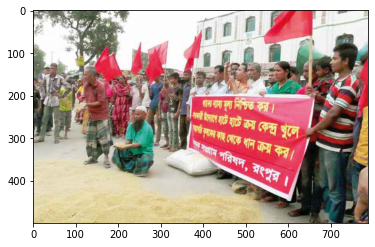

In [ ]:
#url = "https://drive.google.com/file/d/1AvnspVCRze8OyimM7wXKIKeL5D4rukWU/view?usp=sharing" #sample image
#url = "https://images.app.goo.gl/sWw6qiQqWHqhrC738"
#image = Image.open(requests.get(url, stream = True).raw)
'''import imageio
image = imageio.imread('E:/Masters/mammals.jpg')
import matplotlib.image as mpimg
image = mpimg.imread('E:/Masters/mammals.jpg')
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('Sydney-Opera-House.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()'''
#plt.imshow(image)
#plt.show()
'''
image = !gdown --id 1AvnspVCRze8OyimM7wXKIKeL5D4rukWU/view?usp=sharing
plt.imshow(image)
plt.show()'''
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('BDApps1.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
plt.imshow(image)
plt.show()

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# COCO classes
CLASSES = ['N/A', 'Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane', 'Bus', 
           'Train', 'Truck', 'Boat', 'Traffic-Light', 'Fire-Hydrant', 'N/A', 'Stop-Sign',
           'Parking Meter', 'Bench', 'Bird', 'Cat', 'Dog', 'Horse', 'Sheep', 'Cow', 'Elephant',
           'Bear', 'Zebra', 'Giraffe', 'N/A', 'Backpack', 'Umbrella', 'N/A', 'N/A', 'Handbag', 
           'Tie', 'Suitcase', 'Frisbee', 'Skis', 'Snowboard', 'Sports-Ball', 'Kite', 'Baseball Bat',
           'Baseball Glove', 'Skateboard', 'Surfboard', 'Tennis Racket', 'Bottle', 'N/A', 
           'Wine Glass', 'Cup', 'Fork', 'Knife', 'Spoon', 'Bowl', 'Banana', 'Apple', 'Sandwich', 
           'Orange', 'Broccoli', 'Carrot', 'Hot-Dog', 'Pizza', 'Donut', 'Cake', 'Chair', 'Couch', 
           'Potted Plant', 'Bed', 'N/A', 'Dining Table', 'N/A','N/A', 'Toilet', 'N/A', 'TV', 'Laptop',
           'Mouse', 'Remote', 'Keyboard', 'Cell-Phone', 'Microwave', 'Oven', 'Toaster', 
           'Sink', 'Refrigerator', 'N/A', 'Book', 'Clock', 'Vase', 'Scissors', 'Teddy-Bear',
           'Hair-Dryer', 'Toothbrush']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# Get coordinates (x0, y0, x1, y0) from model output (x, y, w, h)
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=1)

In [ ]:
# Scale box from [0,1] x [0,1] to [0, width] x [0, height]
def scale_boxes(output_box, width, height):
  box_coords = get_box_coords(output_box)
  scale_tensor = torch.Tensor([width, height, width, height]).to(torch.cuda.current_device())
  return box_coords * scale_tensor

In [ ]:
import torch
from torchvision import transforms as T

if torch.cuda.is_available():
      device = 'cuda'
      print("Using GPU")
else:
      device = 'cpu'
      print("Using CPU")

Using GPU


In [ ]:
def detect(im, model, transform):
    device = torch.cuda.current_device()
    '''device = args.device # "cuda" / "cpu"
    if "cuda" in device and not torch.cuda.is_available():
      device = "cpu"
    data = data.to(device)
    detr.to(device)
    if torch.cuda.is_available():
      device = 'cuda'
    else:
      device = 'cpu'
      '''
    #data = data.to(device)
    model.to(device)
    width = im.size[0]
    height = im.size[1]
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.85

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = scale_boxes(outputs['pred_boxes'][0, keep], width, height)
    return probas[keep], bboxes_scaled

In [ ]:
probs, bboxes = detect(image, detr, transform)

In [ ]:
#plot predicted bounding box
def plot_results(pil_img, prob, boxes,labels=True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                   fill=False, color=color, linewidth=2))
        cl = prob.argmax()
        text = f'{CLASSES[cl]}: {prob[cl]:0.2f}'
        if labels:
          ax.text(x0, y0, text, fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
    plt.axis('off')
    plt.show()

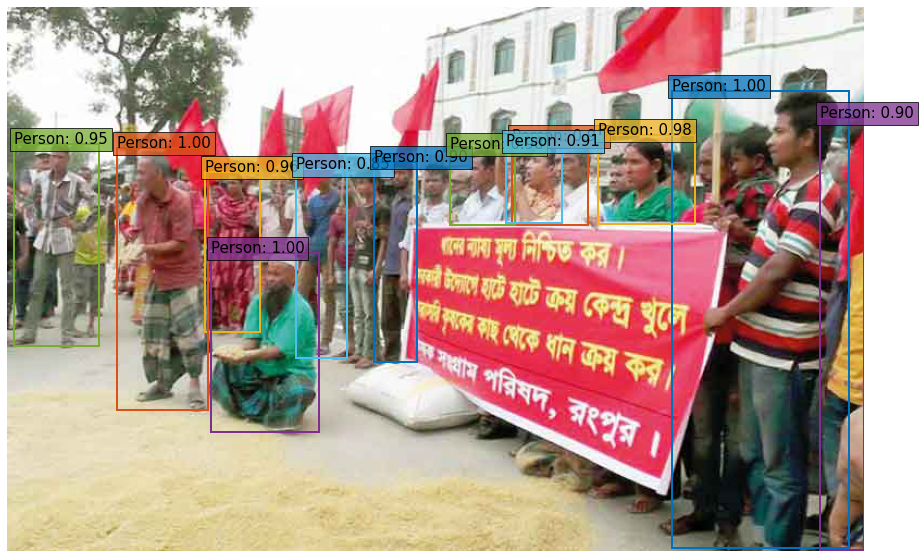

In [ ]:
plot_results(image, probs, bboxes, labels = True)